# An Example of Linear inverse modeling 

### Code adapted from Aneesh CSs Matlab example. (Sept. 2015)
An updated (bug fixed) version of his matlab code is also in this repo. 

#### Which was partly aderived from Oxford Code (ref. L. Zanna) 



#### Libraries: 

In [573]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.linalg import logm, expm
from scipy.sparse.linalg import eigs

## Initial Variables

In [604]:
#size of the sample data matrix:
ND=6;

#Number of leading modes to keep (NM)
NM=6;

#length of sample timeseries
LEN=100;

#lead time for the lag covariance matrix (Ideally the LIM model should be
#insensitive to the length of tau, Newman 2007 J. Clim.)
tau=1;

#amplitude of random number
amp_rand=0.04;

#Sample coefficient matrix to test the LIM on
A = np.array([0.6473, 0.7794, -0.2384, -0.2514, 0.2725, 0.1545,
              0.3763, -0.0788, 0.2912, 0.0157, 0.5366, 0.4495,
              0.1415, -0.1115, 0.6313, 1.0658,   -0.1281,   -0.6122,
              0.2403, -0.6710, -0.5115, -1.2562, 0.3314,   -0.2627,
              -0.6190, 0.8029, 0.2052, -1.2039, 0.8788,    1.3340,
              0.2461, -0.5397, -0.1025, -0.5906, 0.1451,    0.6633]).reshape(6,6)

xp = np.zeros([ND,LEN])*np.nan

## Time Stepping Initial

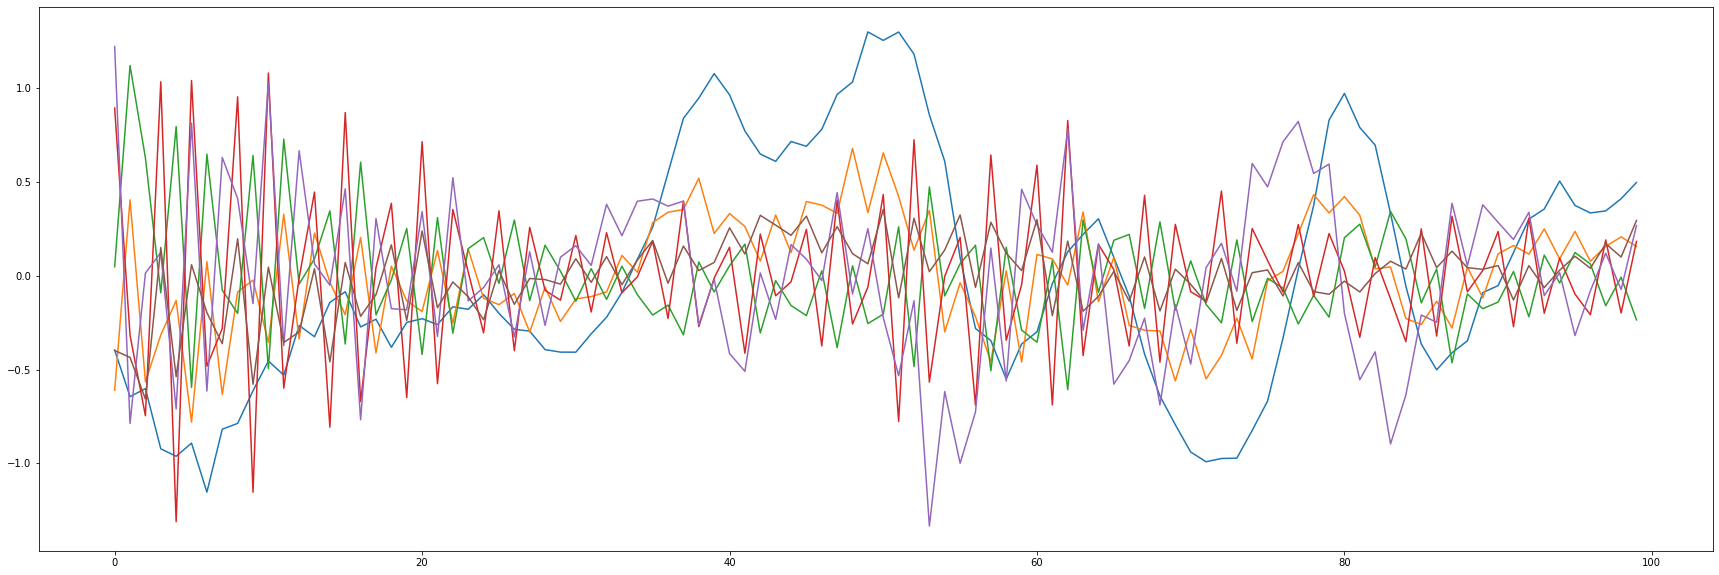

In [605]:
#random initialization!
xp[:,0]= np.random.randn(ND,1).squeeze()

#time step according to A:
for tt in range(LEN-1):
    xp[:,tt+1]=np.matmul(A,xp[:,tt]) + amp_rand*np.random.randn(ND,1).T;

#temporal anomalies 
for ii in range(ND):
    xp[ii,:]=xp[ii,:]-np.mean(xp[ii,:]);

plt.figure(figsize=(30,10))
plt.plot(xp[:,:].T)
plt.show()

### SVD Decomposition

In [606]:
[U,S,V]=np.linalg.svd(xp.T,0);

#Keep on NM number of modes
x=copy.deepcopy(U[:,0:NM].T)
y=copy.deepcopy(V[0:NM,0:NM])

#Trace of eigenvalue matrix
tr=np.sum((S)**2);

# fraction of variance explained
FVE = (S)**2 / tr 

# normalize time series and scale in singular values to retain variance
for ii in range(NM):
    n=np.var(x[ii,:]);
    x[ii,:] = x[ii,:]/n;
    y[ii,:] = y[ii,:]*n*S[ii];

sanity check


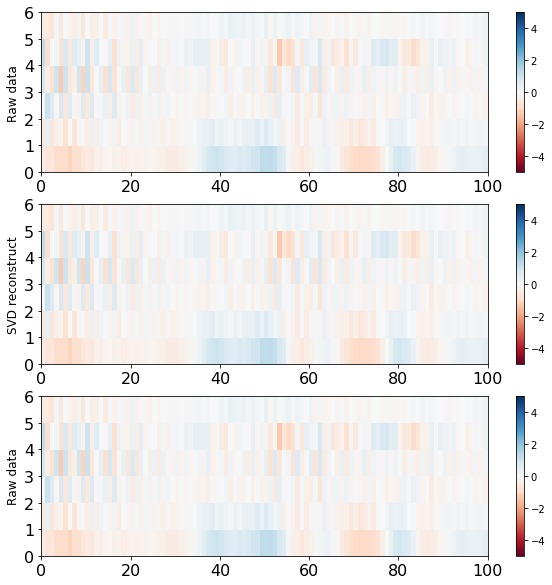

In [607]:
# [U,S,V]=np.linalg.svd(xp.T,0);

print('sanity check')
# check reconstructed timeseries ok
plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)
plt.pcolor(xp,vmin=-5,vmax=5,cmap='RdBu')
plt.colorbar()
plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)
plt.ylabel('Raw data',fontsize = 12);

ax1 = plt.subplot(312)
plt.pcolor(np.dot(U * S, V).T,vmin=-5,vmax=5,cmap='RdBu')
plt.colorbar()
plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)
plt.ylabel('SVD reconstruct',fontsize = 12);

ax1 = plt.subplot(313)
plt.pcolor(np.matmul(x.T,y).T,vmin=-5,vmax=5,cmap='RdBu')
plt.colorbar()
plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)
plt.ylabel('Raw data',fontsize = 12);

## Now LIM 

In [608]:
# weight x by sqrt(FVE) for Optimal Perturbation analysis
for ii in range(NM):
    x[ii,:] = x[ii,:]*np.sqrt(FVE[ii]);

# Create LIM matrix
s=np.shape(x);
Clag = np.zeros([s[0],s[0]]); #lagged matrix! 

for ii in range(s[1]-tau):
    Clag = Clag + (np.matmul(np.expand_dims(x[:,ii+tau],1),(np.expand_dims(x[:,ii],1).T)));

#Compute the zero lag covariance matrix
C = np.matmul(x,x.T) / (s[1]-1);

# Normalize lag covariance matrix
Clag = Clag / (s[1]-tau-1);

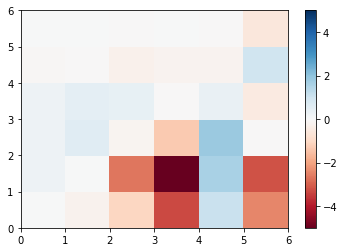

In [609]:
# Constructing the LIM matrix
B = logm(np.matmul(Clag,np.linalg.inv(C)))/tau; 
plt.pcolor(B,cmap='RdBu',vmin=-5,vmax=5)
plt.colorbar()
plt.show()

## Integrate Forward in time

In [610]:
lprop = np.zeros((NM,NM,LEN))*np.nan;

for tt in range(LEN):
    lprop[:,:,tt] = expm(B*tt);


## EigValues and Vectors of Propagator matrix

In [611]:
# Eigenvalues and eigenvectors of Propagator matrix
kk=1;
amp_energy=np.zeros(LEN+1)
ev=np.zeros([NM,LEN+1])
tim=np.zeros(LEN+1)
for tt in range(LEN):
    PROP = expm(B*tt);
    [w,q]=eigs(np.matmul(PROP.T,PROP),NM); #returns ordered eigen values. 
    amp_energy[kk] = np.max(w[0]);
#     print(np.sqrt(np.matmul(np.expand_dims(q[:,0],1).T,np.expand_dims(q[:,0],1))))
    q = q[:,0] / np.sqrt(np.matmul(np.expand_dims(q[:,0],1).T,np.expand_dims(q[:,0],1)))
    ev[:,kk]= q.squeeze();
    tim[kk]=tt;
    kk+=1;


/Users/wchapman/anaconda3/envs/Hawaii/lib/python3.6/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


## Original Growth

In [612]:
# % %% original growth 
indx_t=0; 
dt=1;
sig_orig = np.zeros([LEN+1])*np.nan;
for tt in range(0,100):
    indx_t=tt;
    [D1,V1]=eigs(np.matmul(np.linalg.matrix_power(A, tt).T,np.linalg.matrix_power(A, tt)))
    sig_orig[indx_t] = np.max((D1)); 

/Users/wchapman/anaconda3/envs/Hawaii/lib/python3.6/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


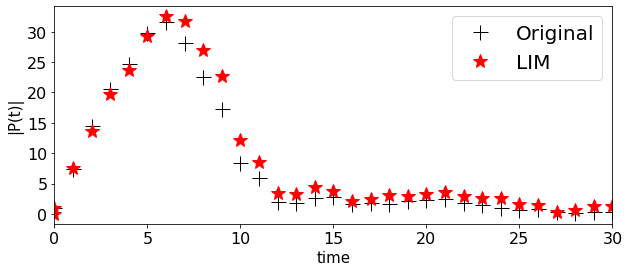

In [622]:
plt.figure(figsize=(10,4))
ax1 = plt.subplot(111)
plt.plot(np.arange(0,101),sig_orig,'k+',markersize=15,label='Original')
plt.plot(tim,amp_energy,'r*',markersize=15,label='LIM');
plt.xlim([0,30])
plt.xlabel('time',fontsize=15)
plt.ylabel('|P(t)|',fontsize=15)
plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)
plt.legend(fontsize=20)
plt.show()